# Projekt z Inżynierii Uczenia Maszynowego
Semestr letni 2020, WEiTI PW
## Autorzy
Przemysław Stawczyk

Maciej Szulik


## Porównanie modeli regresorów:
- kNN
- tree regressor
- xgboost regressor

In [66]:
import json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sn


In [54]:
def clean_nan_rows(dataframe, print_stats=False):
    clean_df = dataframe.dropna(axis=0, how='any')
    if print_stats:
        print('Original Length=', len(dataframe), '\tCleaned Length=', len(clean_df), '\tMissing Data=',
              len(dataframe) - len(clean_df))
    return clean_df

def load_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data]  # convert string to dict format
        df = pd.json_normalize(data)
    return df

def load_tables():
    users = load_file(r'../data/users.jsonl')
    deliveries = load_file(r'../data//deliveries.jsonl')
    sessions = load_file(r'../data//sessions.jsonl')
    products = load_file(r'../data//products.jsonl')

    return users, deliveries, sessions, products

def create_subcategories(products):
    category_path_arr = products['category_path'].str.split(';', 2)
    category_arr = []
    subcategory_arr = []
    for path in category_path_arr:
        if type(path) == float:
            category_arr.append(path)
            subcategory_arr.append(path)
        else:
            category_arr.append(path[0])
            subcategory_arr.append(path[1])

    products['category'] = category_arr
    products['subcategory'] = subcategory_arr

    return products

def fill_missing_user_id(sessions):
    session_user_map = sessions[sessions["user_id"].notna()].set_index('session_id')['user_id'].to_dict()

    for i, row in sessions.iterrows():
        if np.isnan(row["user_id"]) and row["session_id"] in session_user_map:
            sessions.at[i, 'user_id'] = session_user_map[row["session_id"]]

    buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

    clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=False)

    return buy_sessions

def obtain_dataset_table():
    users, deliveries, sessions, products = load_tables()

    # create subcategories and fill missing user id
    products = create_subcategories(products)
    sessions = fill_missing_user_id(sessions)

    # drop deliveries with missing delivery time
    deliveries = deliveries.dropna()

    # inner join sessions and deliveries
    merged_data = pd.merge(left=sessions, right=deliveries, left_on='purchase_id', right_on='purchase_id')

    # left join users
    merged_data = pd.merge(left=merged_data, right=users, how='left', left_on='user_id', right_on='user_id')

    # left join products
    merged_data = pd.merge(left=merged_data, right=products, how='left', left_on='product_id', right_on='product_id')

    # delivery time in hours
    merged_data['delivery_timestamp'] = \
        pd.to_datetime(merged_data.delivery_timestamp)
    merged_data['purchase_timestamp'] = \
        pd.to_datetime(merged_data.purchase_timestamp)
    merged_data['delivery_total_time'] = \
        merged_data['delivery_timestamp'] - merged_data['purchase_timestamp']

    merged_data['delivery_total_time_hours'] = \
        merged_data['delivery_total_time'].dt.total_seconds() / 3600

    # drop unnecessary columns
    columns = ['session_id', 'purchase_id', 'user_id', 'product_id', 'event_type',
               'offered_discount', 'name', 'timestamp', 'product_name', 'street',
               'purchase_timestamp', 'delivery_timestamp', 'category_path']
    for col in columns:
        merged_data = merged_data.drop(col, axis=1)

    merged_data = clean_nan_rows(merged_data, print_stats=False)

    return merged_data

def code_labels(dataset):
    # code labels
    le_cat = preprocessing.LabelEncoder()
    categories = np.unique(np.array(dataset['category']))
    np.append(categories, 'missing')
    le_cat.fit(categories)
    dataset['category'] = le_cat.transform(dataset['category'])

    le_subcat = preprocessing.LabelEncoder()
    subcategories = np.unique(np.array(dataset['subcategory']))
    np.append(subcategories, 'missing')
    le_subcat.fit(subcategories)
    dataset['subcategory'] = le_subcat.transform(dataset['subcategory'])

    le_city = preprocessing.LabelEncoder()
    cities = np.unique(np.array(dataset['city']))
    np.append(cities, 'missing')
    le_city.fit(cities)
    dataset['city'] = le_city.transform(dataset['city'])

    return dataset, le_cat, le_subcat, le_city

In [55]:
dataset = obtain_dataset_table()
dataset, le_cat, le_subcat, le_city = code_labels(dataset)

dataset

,delivery_company,city,price,category,subcategory,delivery_total_time,delivery_total_time_hours
0,360.0,4,109.00,0,4,2 days 23:33:51.034629,71.564176
1,516.0,4,69.00,0,4,2 days 22:24:05.574877,70.401549
2,516.0,4,5259.00,1,2,3 days 04:54:00.187799,76.900052
3,620.0,4,553.00,2,1,2 days 10:19:15.697450,58.321027
4,360.0,4,553.00,2,1,2 days 20:05:36.327567,68.093424
...,...,...,...,...,...,...,...
6485,360.0,7,3029.00,1,5,1 days 07:24:36.353180,31.410098
6486,516.0,7,1816.97,1,7,1 days 21:58:50.399789,45.980667
6487,516.0,7,59.90,0,4,1 days 21:49:11.868149,45.819963
6488,516.0,7,399.00,1,5,2 days 06:54:03.191550,54.900887


In [56]:
target = dataset['delivery_total_time_hours']
data = dataset.drop(['delivery_total_time', 'delivery_total_time_hours'], axis=1)

data

,delivery_company,city,price,category,subcategory
0,360.0,4,109.00,0,4
1,516.0,4,69.00,0,4
2,516.0,4,5259.00,1,2
3,620.0,4,553.00,2,1
4,360.0,4,553.00,2,1
...,...,...,...,...,...
6485,360.0,7,3029.00,1,5
6486,516.0,7,1816.97,1,7
6487,516.0,7,59.90,0,4
6488,516.0,7,399.00,1,5


## Podział zbioru danych na treningowy i testowy

In [57]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

## Trenowanie modeli

Na potrzeby porównania modeli poszukiwanie parametrów na siatce będzie odbywać się wyczerpująco - na potrzeby zwykłego działania sprawdzenie ok ~50% kombinacji powinno przyniesć dobre rezultaty i krtótszy czas trenowania modelu.

In [63]:
def train_model(target, data, model_type='xgb', random_seed=42, randomized=True):
    params = {}
    model = None
    crv = None

    if model_type == 'xgb':
        model = xgb.XGBRegressor()
        params = {
            'objective': ['reg:squarederror'],
            'eval_metric': ['rmse'],
            'learning_rate': [0.03, 0.05, 0.07, 0.12],  # so called `eta` value
            'max_depth': [3, 4, 5, 6, 7, 8, 9],
            'min_child_weight': [1, 2, 4, 7],
            'silent': [1],
            'n_estimators': [100, 200, 320, 450],
            'seed': [random_seed]
        }
    elif model_type == 'tree':
        model = DecisionTreeRegressor()
        params = {
            'max_depth': [3, 4, 5, 6, 7, 8, 9],
            'random_state': [random_seed],
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
        }
    elif model_type == 'knn':
        model = KNeighborsRegressor()
        params = {
            'n_neighbors': [3, 4, 5, 6, 8, 12, 15, 18, 22, 27, 32],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree'],
        }
    elif model_type == 'forrest':
        model = RandomForestRegressor()
        params = {
            'n_estimators': [100, 200, 320, 450],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'random_state': [random_seed],
            'criterion': ['mse', 'mae'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_jobs' : [-1]
        }
    else:
        return NotImplemented

    crv = GridSearchCV(model, params, cv=KFold(n_splits=4, random_state=random_seed, shuffle=True), refit=True,
                           scoring='neg_mean_squared_error')

    crv.fit(data, target)

    return crv.best_estimator_, crv.best_params_

In [64]:
model_knn, params_knn = train_model(y_train, x_train, model_type='knn')
params_knn

{'algorithm': 'kd_tree', 'n_neighbors': 27, 'weights': 'distance'}

In [60]:
model_tree, params_tree = train_model(y_train, x_train, model_type='tree')
params_tree

{'criterion': 'friedman_mse',
 'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'random_state': 42,
 'splitter': 'random'}

In [61]:
model_xgb, params_xgb = train_model(y_train, x_train, model_type='xgb')
params_xgb

{'eval_metric': 'rmse',
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'seed': 42,
 'silent': 1}

In [ ]:
#model_forrest, params_forrest = train_model(y_train, x_train, model_type='forrest', randomized=False)
#params_forrest

## Porównanie modeli na danych testowych

Obliczenie metryk dokładności modeli na zbiorze testowym

In [79]:
def calc_metrics(predictions, test_y):
    err = max_error(test_y, predictions)
    avg = mean_absolute_error(test_y, predictions)
    avg_sqr = mean_squared_error(test_y, predictions)
    
    return [err, avg, avg_sqr]

def compare_models(models, test_X, test_y):
    test_predictions = []
    for mdl in models:
        test_predictions.append(mdl.predict(test_X))

    err = []
    for mdl_pred in test_predictions:
        err.append(calc_metrics(mdl_pred, test_y))

    error = pd.DataFrame.from_records(err, columns=['max error', 'avg error', 'avg sqr error'],
                                      index=['mdl-' + str(index + 1) for index in range(len(models))])
    ret = pd.DataFrame.from_records(test_X)
    ret['target'] = np.asarray(test_y)
    for index, mdl in enumerate(models):
        ret['mdl-' + str(index + 1)] = test_predictions[index]

    return ret, error

In [80]:
predictions, error = compare_models([model_knn, model_tree, model_xgb], x_test, y_test)

error = error.rename(index={'mdl-1': 'kNN', 'mdl-2': 'tree', 'mdl-3': 'xgb'})#, 'mdl-4': 'forrest'})
predictions = predictions.rename(columns={'mdl-1': 'kNN', 'mdl-2': 'tree', 'mdl-3': 'xgb'})#, 'mdl-4': 'forrest'})

predictions['category'] = le_cat.inverse_transform(predictions['category'])
predictions['subcategory'] = le_subcat.inverse_transform(predictions['subcategory'])
predictions['city'] = le_city.inverse_transform(predictions['city'])

error

,max error,avg error,avg sqr error
kNN,55.728228,9.017676,145.308061
tree,28.409592,6.863751,72.505728
xgb,28.513067,6.903586,73.335329


In [81]:
predictions.head(25)

,delivery_company,city,price,category,subcategory,target,kNN,tree,xgb
0,360.0,Konin,1.816970e+03,Komputery,Tablety i akcesoria,36.438362,30.533980,30.316291,30.290058
1,620.0,Gdynia,5.301900e+03,Komputery,Drukarki i skanery,61.118263,57.728998,62.543261,63.193481
2,360.0,Police,1.117010e+03,Komputery,Monitory,72.066114,61.315263,74.377488,74.661026
3,620.0,Police,2.317020e+03,Komputery,Tablety i akcesoria,58.188762,53.939159,52.679625,52.334278
4,620.0,Szczecin,9.999000e+01,Gry i konsole,Gry na konsole,4.241402,15.469892,13.317820,14.467323
5,516.0,Mielec,2.317020e+03,Komputery,Tablety i akcesoria,60.686826,64.659779,63.641483,63.916847
6,360.0,Konin,1.499000e+01,Telefony i akcesoria,Akcesoria telefoniczne,24.254790,28.504562,27.388724,30.924789
7,620.0,Radom,5.530000e+02,Sprzęt RTV,Audio,54.797655,48.811091,49.442918,48.743778
8,516.0,Warszawa,5.990000e+01,Gry i konsole,Gry na konsole,41.185636,47.336212,49.039188,47.895996
9,516.0,Warszawa,1.090000e+02,Sprzęt RTV,Video,41.035450,48.464016,47.321397,47.547367


Jak widać zdecydowanie lepiej radzą sobie modele drzewiaste : XGBoost, DecisionTreeRegressor i RandomForestRegressor. Z naszego doswiadczenia najdłużej trwa trenowanie modeli RandomForestRegressor, a najkrócej DecisionTreeRegressor.

In [82]:
predictions['kNN diff'] = predictions['target'] - predictions['kNN']
predictions['tree diff'] = predictions['target'] - predictions['tree']
predictions['xgb diff'] = predictions['target'] - predictions['xgb']
#predictions['forrest diff'] = predictions['target'] - predictions['forrest']

predictions

,delivery_company,city,price,category,subcategory,target,kNN,tree,xgb,kNN diff,tree diff,xgb diff
0,360.0,Konin,1816.97,Komputery,Tablety i akcesoria,36.438362,30.533980,30.316291,30.290058,5.904382,6.122071,6.148303
1,620.0,Gdynia,5301.90,Komputery,Drukarki i skanery,61.118263,57.728998,62.543261,63.193481,3.389265,-1.424998,-2.075219
2,360.0,Police,1117.01,Komputery,Monitory,72.066114,61.315263,74.377488,74.661026,10.750850,-2.311375,-2.594912
3,620.0,Police,2317.02,Komputery,Tablety i akcesoria,58.188762,53.939159,52.679625,52.334278,4.249603,5.509137,5.854484
4,620.0,Szczecin,99.99,Gry i konsole,Gry na konsole,4.241402,15.469892,13.317820,14.467323,-11.228490,-9.076418,-10.225921
...,...,...,...,...,...,...,...,...,...,...,...,...
1540,360.0,Kutno,79.90,Gry i konsole,Gry na konsole,58.106762,71.033095,62.943671,61.314903,-12.926332,-4.836909,-3.208141
1541,360.0,Kutno,189.00,Sprzęt RTV,Video,66.240267,53.916527,59.514647,60.455761,12.323740,6.725620,5.784506
1542,620.0,Warszawa,2199.90,Telefony i akcesoria,Telefony komórkowe,30.250557,32.149135,32.149135,32.957172,-1.898578,-1.898578,-2.706615
1543,516.0,Radom,119.00,Sprzęt RTV,Video,68.037479,49.440315,65.957018,66.134171,18.597164,2.080461,1.903308


### Rozkład błędów modeli

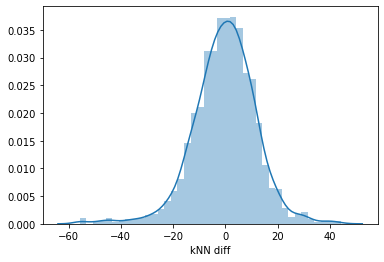

In [90]:
sn.distplot(predictions['kNN diff'], bins=40)

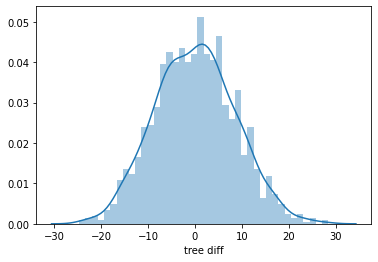

In [87]:
sn.distplot(predictions['tree diff'], bins=40)

In [85]:
#sn.distplot(predictions['forrest diff'], bins=50)

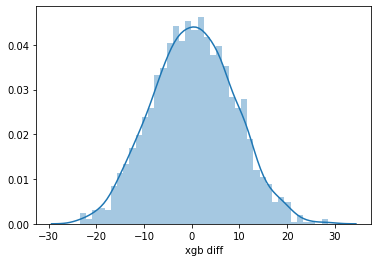

In [88]:
sn.distplot(predictions['xgb diff'], bins=40)

Jak widać w praktyce najgorzej radzi sobie model kNN, posiada też wyraźn, co pokrywa się z naszymi przewidywaniami. Róznice pomiędzy pomiędzy pozostałymi modelami na zbiorze testowym są naprawdę minimalne. Wybór pomiędzy nimi zależy od innych kryteriów jak np. czas trenowania modelu. Z tego powodu zdecydowaliśmy sie na model *DecisionTreeRegressor*
